# Getting Norm Notebook

In [1]:
import pyrealsense2 as rs
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setup
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
profile = pipeline.start(config)
depth_sensor = profile.get_device().first_depth_sensor()
depth_scale = depth_sensor.get_depth_scale()
align_to = rs.stream.color
align = rs.align(align_to)

In [28]:
frames = pipeline.wait_for_frames()
aligned_frames = align.process(frames)
aligned_depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()
depth_image = np.asanyarray(aligned_depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

## Analyze Color Image

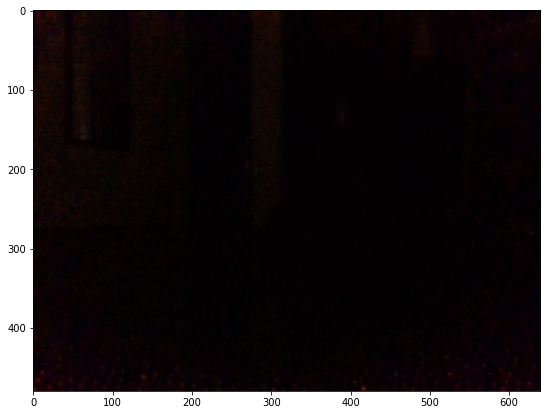

In [29]:
plt.figure(figsize=(10, 7))
plt.imshow(color_image)
plt.show()

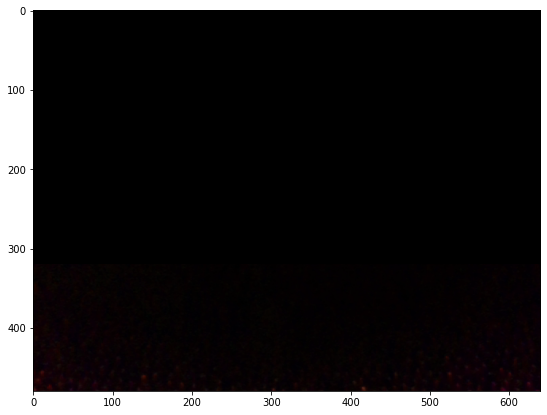

In [30]:
start = (320, 0)
end   = (480, 640)

edit_color = np.array(color_image)
edit_color[:start[0], :, :] = 0
edit_color[end[0]:  , :, :] = 0
edit_color[:, :start[1], :] = 0
edit_color[:,   end[1]:, :] = 0

plt.figure(figsize=(10, 7))
plt.imshow(edit_color)
plt.show()

## Get Reference Norm from Depth

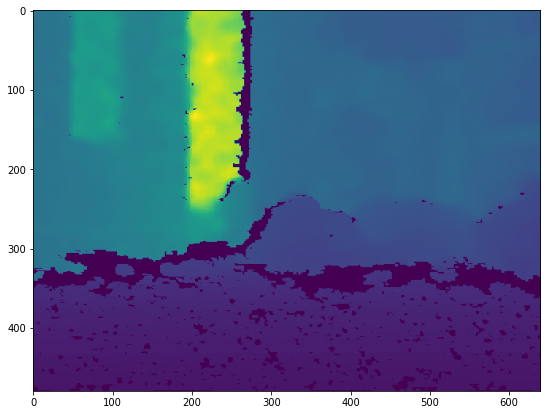

In [31]:
plt.figure(figsize=(10, 7))
plt.imshow(depth_image)
plt.show()

In [32]:
pc = rs.pointcloud()
points = pc.calculate(aligned_depth_frame)
vtx = np.ndarray(
    buffer=points.get_vertices(), dtype=np.float32, shape=(640*480, 3)
)

In [33]:
select_idx = (edit_color.mean(axis=2) > 0).flatten()
select_idx

array([False, False, False, ...,  True,  True,  True])

In [34]:
reference_vtx = vtx[select_idx]
rand_idx = np.random.choice(
    np.arange(reference_vtx.shape[0]), 4000, replace=False
)
ref_sample = reference_vtx[rand_idx]
ref_mean = ref_sample.mean(axis=0)

In [35]:
_, _, vt = np.linalg.svd(ref_sample - ref_mean)

In [36]:
norm = vt[2]
norm

array([ 0.0091827 , -0.98954576,  0.14392653], dtype=float32)

## Test Norm on Depth Image

In [37]:
color_image.shape

(480, 640, 3)

In [38]:
def normalize_v3(arr):
    lens = np.sqrt(arr[:, 0]**2 + arr[:,1]**2 + arr[:,2]**2) + 1e-10
    arr[:,0] /= lens
    arr[:,1] /= lens
    arr[:,2] /= lens
    return arr

d1, d2, _ = color_image.shape
idx, jdx = np.indices((d1, d2))
idx_back = np.clip(idx - 1, 0, idx.max()).flatten()
idx_front = np.clip(idx + 1, 0, idx.max()).flatten()
jdx_back = np.clip(jdx - 1, 0, jdx.max()).flatten()
jdx_front = np.clip(jdx + 1, 0, jdx.max()).flatten()
idx = idx.flatten()
jdx = jdx.flatten()

rand_idx = np.random.choice(np.arange(idx.shape[0]), size=300000, replace=False)
f1 = (idx_front * d2 + jdx)[rand_idx]
f2 = (idx_back  * d2 + jdx)[rand_idx]
f3 = (idx * d2 + jdx_front)[rand_idx]
f4 = (idx * d2 + jdx_back )[rand_idx]
norm_fill = np.zeros((idx.shape[0]))

In [39]:
x = vtx[f1, :] - vtx[f2, :]
y = vtx[f3, :] - vtx[f4, :]
xyz_norm = normalize_v3(np.cross(x, y))
norm_flat = xyz_norm @ norm
norm_fill[rand_idx] = norm_flat
norm_matrix = np.abs(norm_fill.reshape((d1, d2)))

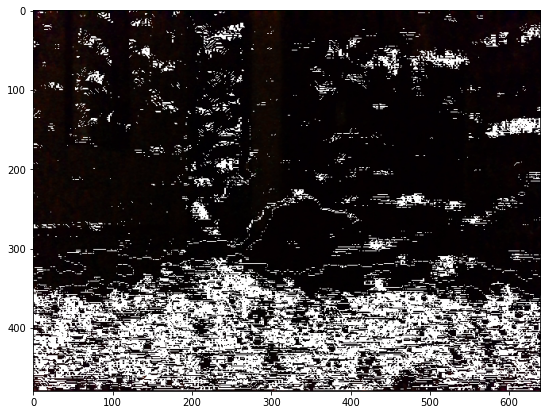

In [40]:
edit_color2 = np.array(color_image)
edit_color2[norm_matrix > 0.95] = 255

plt.figure(figsize=(10, 7))
plt.imshow(edit_color2)
plt.show()